<a href="https://colab.research.google.com/github/anpham1331372/ECGR5106/blob/main/ECGR5106_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10, Train Loss: 2.6265, Val Loss: 2.7473, Val Acc: 0.3068
Epoch 20, Train Loss: 2.2763, Val Loss: 2.7471, Val Acc: 0.3466
Epoch 30, Train Loss: 2.0621, Val Loss: 2.8177, Val Acc: 0.3745
Epoch 40, Train Loss: 1.8645, Val Loss: 2.9452, Val Acc: 0.3745
Epoch 50, Train Loss: 1.7411, Val Loss: 3.0677, Val Acc: 0.3546
Epoch 60, Train Loss: 1.6364, Val Loss: 3.1315, Val Acc: 0.3506
Epoch 70, Train Loss: 1.5855, Val Loss: 3.1796, Val Acc: 0.3506
Epoch 80, Train Loss: 1.5028, Val Loss: 3.2425, Val Acc: 0.3386
Epoch 90, Train Loss: 1.4587, Val Loss: 3.2854, Val Acc: 0.3506
Epoch 100, Train Loss: 1.3788, Val Loss: 3.3356, Val Acc: 0.3386
Epoch 110, Train Loss: 1.3871, Val Loss: 3.3658, Val Acc: 0.3307
Epoch 120, Train Loss: 1.3440, Val Loss: 3.4037, Val Acc: 0.3267
Epoch 130, Train Loss: 1.3041, Val Loss: 3.4366, Val Acc: 0.3108
Epoch 140, Train Loss: 1.3084, Val Loss: 3.4591, Val Acc: 0.3386
Epoch 150, Train Loss: 1.2603, Val Loss: 3.4792, Val Acc: 0.3147
Epoch 160, Train Loss: 1.2372, Val

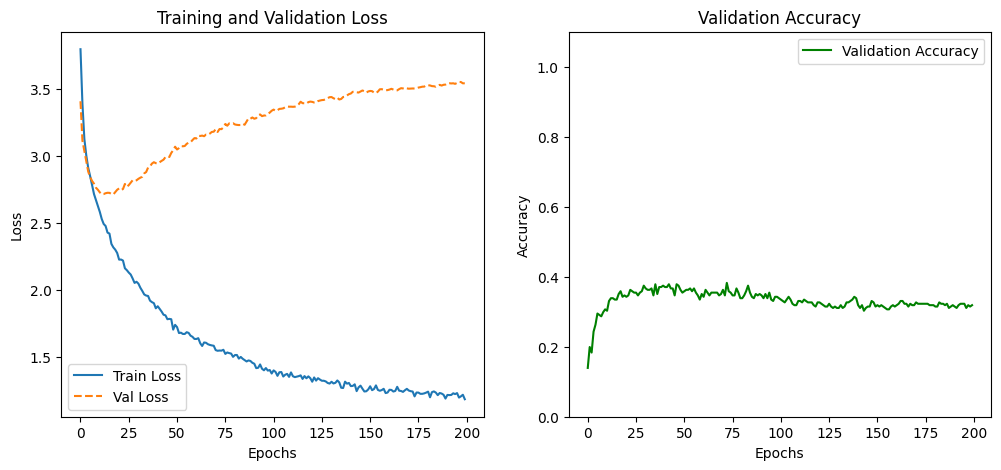

Predicted next character: ' '


In [12]:
#Problem 1: RNN Sequence 10

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """
Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 10
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Improved RNN model
class ImprovedCharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(ImprovedCharRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = ImprovedCharRNN(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 1: RNN Sequence 20

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """
Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 20
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Improved RNN model
class ImprovedCharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(ImprovedCharRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = ImprovedCharRNN(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 1: RNN Sequence 30

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """
Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 30
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Improved RNN model
class ImprovedCharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(ImprovedCharRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = ImprovedCharRNN(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


Epoch 10, Train Loss: 2.8534, Val Loss: 3.0559, Val Acc: 0.2280
Epoch 20, Train Loss: 2.3589, Val Loss: 2.9345, Val Acc: 0.2760
Epoch 30, Train Loss: 2.0083, Val Loss: 2.9028, Val Acc: 0.3040
Epoch 40, Train Loss: 1.7415, Val Loss: 2.9662, Val Acc: 0.3280
Epoch 50, Train Loss: 1.4584, Val Loss: 3.0658, Val Acc: 0.2880
Epoch 60, Train Loss: 1.3621, Val Loss: 3.1161, Val Acc: 0.3040
Epoch 70, Train Loss: 1.2639, Val Loss: 3.1892, Val Acc: 0.3000
Epoch 80, Train Loss: 1.2108, Val Loss: 3.2507, Val Acc: 0.2960
Epoch 90, Train Loss: 1.1677, Val Loss: 3.3426, Val Acc: 0.3080
Epoch 100, Train Loss: 1.1204, Val Loss: 3.3656, Val Acc: 0.3080
Epoch 110, Train Loss: 1.0599, Val Loss: 3.3946, Val Acc: 0.3160
Epoch 120, Train Loss: 1.0699, Val Loss: 3.3995, Val Acc: 0.3200
Epoch 130, Train Loss: 1.0228, Val Loss: 3.4361, Val Acc: 0.3160
Epoch 140, Train Loss: 1.0278, Val Loss: 3.4687, Val Acc: 0.3160
Epoch 150, Train Loss: 1.0197, Val Loss: 3.4583, Val Acc: 0.3120
Epoch 160, Train Loss: 1.0075, Val

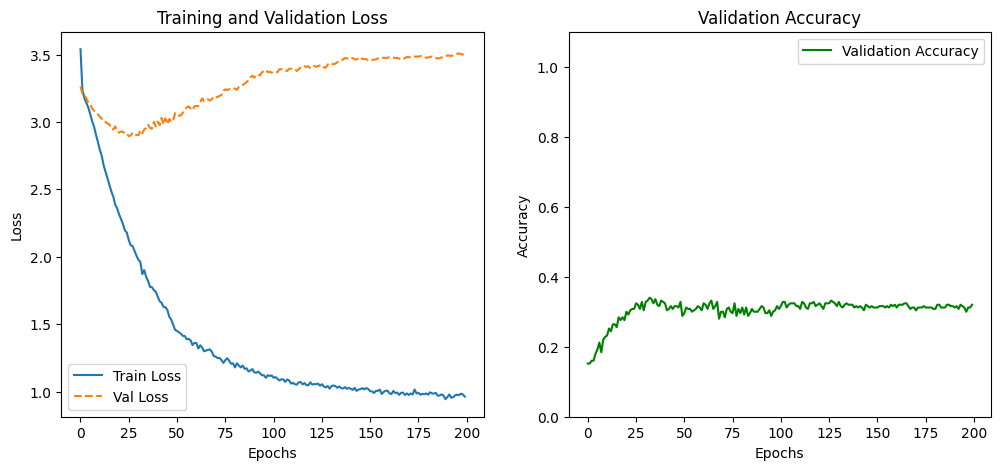

Predicted next character: 'n'


In [13]:
#Problem 1: LSTM Length 10
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 10
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the LSTM-based model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 1: LSTM Length 20
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 20
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the LSTM-based model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 1: LSTM Length 30
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 30
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the LSTM-based model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


Epoch 10, Train Loss: 2.8182, Val Loss: 2.9979, Val Acc: 0.2160
Epoch 20, Train Loss: 2.4027, Val Loss: 2.8365, Val Acc: 0.3280
Epoch 30, Train Loss: 2.0574, Val Loss: 2.7999, Val Acc: 0.3360
Epoch 40, Train Loss: 1.8369, Val Loss: 2.8647, Val Acc: 0.3480
Epoch 50, Train Loss: 1.6065, Val Loss: 2.9229, Val Acc: 0.3600
Epoch 60, Train Loss: 1.4963, Val Loss: 2.9675, Val Acc: 0.3720
Epoch 70, Train Loss: 1.4478, Val Loss: 3.0305, Val Acc: 0.3680
Epoch 80, Train Loss: 1.3821, Val Loss: 3.0667, Val Acc: 0.3720
Epoch 90, Train Loss: 1.2941, Val Loss: 3.0970, Val Acc: 0.3440
Epoch 100, Train Loss: 1.2533, Val Loss: 3.1331, Val Acc: 0.3640
Epoch 110, Train Loss: 1.1841, Val Loss: 3.1793, Val Acc: 0.3640
Epoch 120, Train Loss: 1.1651, Val Loss: 3.2060, Val Acc: 0.3560
Epoch 130, Train Loss: 1.1636, Val Loss: 3.2296, Val Acc: 0.3480
Epoch 140, Train Loss: 1.1244, Val Loss: 3.2450, Val Acc: 0.3400
Epoch 150, Train Loss: 1.1196, Val Loss: 3.2630, Val Acc: 0.3560
Epoch 160, Train Loss: 1.0916, Val

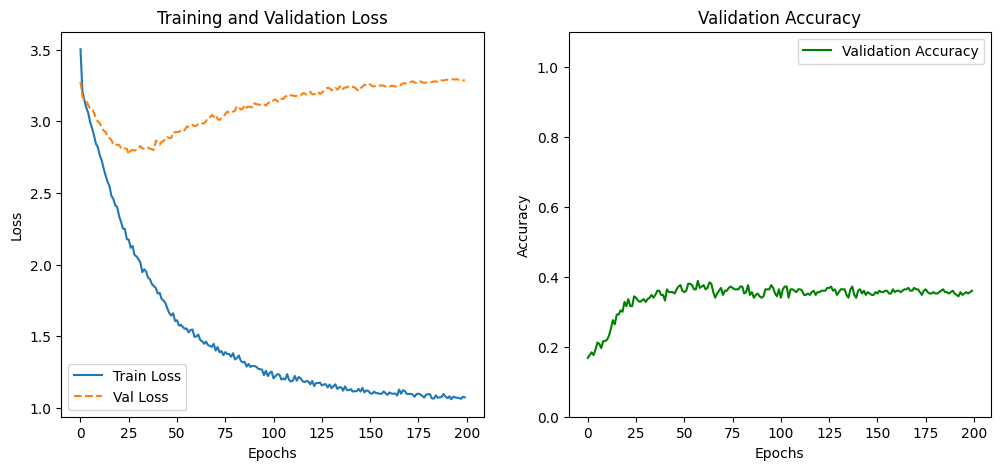

Predicted next character: 'n'


In [14]:
#Problem 1: GRU Length 10
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 10
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the GRU-based model
class GRUCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(GRUCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = GRUCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 1: GRU Length 20
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# Sample text
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it.
This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks.
RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character.
LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
"""

# Creating character vocabulary
chars = sorted(set(text))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Prepare dataset
max_length = 20
X, y = [], []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders for mini-batching
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the GRU-based model
class GRUCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(GRUCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.layer_norm(output)
        output = self.fc(output[:, -1, :])
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.0005
epochs = 200

# Initialize model, loss function, optimizer
model = GRUCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring execution time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            val_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# End measuring execution time
end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1.1)  # Ensuring it doesn’t get too close to 1

# Show the plots
plt.show()

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length=15):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_ix[c] for c in initial_str[-max_length:] if c in char_to_ix]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predict the next character
test_str = "Next character prediction is a fundame"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


Epoch 1/100: 100%|██████████| 3125/3125 [00:32<00:00, 94.96batch/s, acc=40.92%, loss=1.81] 


Epoch 1/100 | Time: 35.96s | Train Loss: 2.0795 | Test Loss: 1.7539 | Test Acc: 48.65%


Epoch 2/100: 100%|██████████| 3125/3125 [00:29<00:00, 107.06batch/s, acc=49.63%, loss=1.63]


Epoch 2/100 | Time: 33.09s | Train Loss: 1.7014 | Test Loss: 1.6077 | Test Acc: 52.02%


Epoch 3/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.52batch/s, acc=52.32%, loss=1.43]


Epoch 3/100 | Time: 32.72s | Train Loss: 1.5912 | Test Loss: 1.5326 | Test Acc: 53.97%


Epoch 4/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.37batch/s, acc=53.86%, loss=1.7]


Epoch 4/100 | Time: 33.73s | Train Loss: 1.5247 | Test Loss: 1.4848 | Test Acc: 55.07%


Epoch 5/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.30batch/s, acc=55.04%, loss=1.33]


Epoch 5/100 | Time: 33.72s | Train Loss: 1.4771 | Test Loss: 1.4552 | Test Acc: 55.88%


Epoch 6/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.93batch/s, acc=55.99%, loss=1.33]


Epoch 6/100 | Time: 32.56s | Train Loss: 1.4423 | Test Loss: 1.4354 | Test Acc: 56.28%


Epoch 7/100: 100%|██████████| 3125/3125 [00:30<00:00, 103.87batch/s, acc=56.69%, loss=1.13]


Epoch 7/100 | Time: 33.20s | Train Loss: 1.4115 | Test Loss: 1.4124 | Test Acc: 56.85%


Epoch 8/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.95batch/s, acc=57.29%, loss=1.42]


Epoch 8/100 | Time: 33.41s | Train Loss: 1.3876 | Test Loss: 1.3944 | Test Acc: 57.39%


Epoch 9/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.89batch/s, acc=57.89%, loss=1.3]


Epoch 9/100 | Time: 32.57s | Train Loss: 1.3660 | Test Loss: 1.3857 | Test Acc: 57.60%


Epoch 10/100: 100%|██████████| 3125/3125 [00:31<00:00, 97.95batch/s, acc=58.39%, loss=1.27] 


Epoch 10/100 | Time: 35.04s | Train Loss: 1.3467 | Test Loss: 1.3756 | Test Acc: 57.95%


Epoch 11/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.08batch/s, acc=58.82%, loss=1.31]


Epoch 11/100 | Time: 34.96s | Train Loss: 1.3303 | Test Loss: 1.3702 | Test Acc: 58.08%


Epoch 12/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.77batch/s, acc=59.13%, loss=1.27]


Epoch 12/100 | Time: 34.72s | Train Loss: 1.3143 | Test Loss: 1.3648 | Test Acc: 58.27%


Epoch 13/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.64batch/s, acc=59.58%, loss=1.33] 


Epoch 13/100 | Time: 38.08s | Train Loss: 1.3009 | Test Loss: 1.3601 | Test Acc: 58.26%


Epoch 14/100: 100%|██████████| 3125/3125 [00:29<00:00, 104.28batch/s, acc=59.82%, loss=1.59]


Epoch 14/100 | Time: 33.07s | Train Loss: 1.2879 | Test Loss: 1.3539 | Test Acc: 58.49%


Epoch 15/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.66batch/s, acc=60.16%, loss=1.11]


Epoch 15/100 | Time: 34.12s | Train Loss: 1.2747 | Test Loss: 1.3510 | Test Acc: 58.72%


Epoch 16/100: 100%|██████████| 3125/3125 [00:29<00:00, 104.98batch/s, acc=60.50%, loss=1.11]


Epoch 16/100 | Time: 33.70s | Train Loss: 1.2636 | Test Loss: 1.3509 | Test Acc: 58.55%


Epoch 17/100: 100%|██████████| 3125/3125 [00:29<00:00, 105.06batch/s, acc=60.79%, loss=1.14]


Epoch 17/100 | Time: 32.86s | Train Loss: 1.2527 | Test Loss: 1.3486 | Test Acc: 58.87%


Epoch 18/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.44batch/s, acc=61.09%, loss=1.47]


Epoch 18/100 | Time: 33.61s | Train Loss: 1.2412 | Test Loss: 1.3456 | Test Acc: 58.87%


Epoch 19/100: 100%|██████████| 3125/3125 [00:29<00:00, 104.68batch/s, acc=61.27%, loss=1.1]


Epoch 19/100 | Time: 33.87s | Train Loss: 1.2319 | Test Loss: 1.3463 | Test Acc: 58.95%


Epoch 20/100: 100%|██████████| 3125/3125 [00:29<00:00, 104.60batch/s, acc=61.56%, loss=1.08]


Epoch 20/100 | Time: 32.93s | Train Loss: 1.2221 | Test Loss: 1.3488 | Test Acc: 58.99%


Epoch 21/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.07batch/s, acc=61.75%, loss=1.26]


Epoch 21/100 | Time: 33.77s | Train Loss: 1.2127 | Test Loss: 1.3455 | Test Acc: 58.84%


Epoch 22/100: 100%|██████████| 3125/3125 [00:29<00:00, 104.56batch/s, acc=62.10%, loss=1.12]


Epoch 22/100 | Time: 34.00s | Train Loss: 1.2041 | Test Loss: 1.3488 | Test Acc: 59.05%


Epoch 23/100: 100%|██████████| 3125/3125 [00:30<00:00, 103.71batch/s, acc=62.29%, loss=1.35]


Epoch 23/100 | Time: 33.21s | Train Loss: 1.1949 | Test Loss: 1.3525 | Test Acc: 58.74%


Epoch 24/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.06batch/s, acc=62.52%, loss=1.18]


Epoch 24/100 | Time: 33.69s | Train Loss: 1.1870 | Test Loss: 1.3497 | Test Acc: 58.94%


Epoch 25/100: 100%|██████████| 3125/3125 [00:30<00:00, 103.47batch/s, acc=62.74%, loss=1.13]


Epoch 25/100 | Time: 33.99s | Train Loss: 1.1778 | Test Loss: 1.3542 | Test Acc: 58.94%


Epoch 26/100: 100%|██████████| 3125/3125 [00:30<00:00, 104.06batch/s, acc=62.98%, loss=1.02]


Epoch 26/100 | Time: 33.12s | Train Loss: 1.1713 | Test Loss: 1.3555 | Test Acc: 58.87%


Epoch 27/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.67batch/s, acc=63.16%, loss=1.12]


Epoch 27/100 | Time: 33.82s | Train Loss: 1.1625 | Test Loss: 1.3577 | Test Acc: 58.90%


Epoch 28/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.94batch/s, acc=63.38%, loss=1.34]


Epoch 28/100 | Time: 33.92s | Train Loss: 1.1554 | Test Loss: 1.3586 | Test Acc: 59.08%


Epoch 29/100: 100%|██████████| 3125/3125 [00:30<00:00, 103.23batch/s, acc=63.54%, loss=1.2]


Epoch 29/100 | Time: 33.65s | Train Loss: 1.1489 | Test Loss: 1.3591 | Test Acc: 58.88%


Epoch 30/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.13batch/s, acc=63.72%, loss=0.993]


Epoch 30/100 | Time: 34.10s | Train Loss: 1.1418 | Test Loss: 1.3623 | Test Acc: 58.95%


Epoch 31/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.95batch/s, acc=64.86%, loss=1.07]


Epoch 31/100 | Time: 34.38s | Train Loss: 1.1039 | Test Loss: 1.3581 | Test Acc: 59.19%


Epoch 32/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.98batch/s, acc=65.21%, loss=1.26]


Epoch 32/100 | Time: 34.61s | Train Loss: 1.0930 | Test Loss: 1.3635 | Test Acc: 59.01%


Epoch 33/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.43batch/s, acc=65.42%, loss=0.983]


Epoch 33/100 | Time: 33.63s | Train Loss: 1.0868 | Test Loss: 1.3642 | Test Acc: 59.18%


Epoch 34/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.00batch/s, acc=65.50%, loss=1.16]


Epoch 34/100 | Time: 34.34s | Train Loss: 1.0812 | Test Loss: 1.3682 | Test Acc: 58.99%


Epoch 35/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.04batch/s, acc=65.65%, loss=1.05]


Epoch 35/100 | Time: 34.44s | Train Loss: 1.0755 | Test Loss: 1.3732 | Test Acc: 58.96%


Epoch 36/100: 100%|██████████| 3125/3125 [00:30<00:00, 102.31batch/s, acc=65.88%, loss=1.21]


Epoch 36/100 | Time: 34.10s | Train Loss: 1.0702 | Test Loss: 1.3735 | Test Acc: 58.85%


Epoch 37/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.52batch/s, acc=65.95%, loss=1.13]


Epoch 37/100 | Time: 34.22s | Train Loss: 1.0649 | Test Loss: 1.3795 | Test Acc: 58.85%


Epoch 38/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.45batch/s, acc=66.04%, loss=1.13] 


Epoch 38/100 | Time: 34.86s | Train Loss: 1.0612 | Test Loss: 1.3829 | Test Acc: 58.93%


Epoch 39/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.62batch/s, acc=66.22%, loss=1.09]


Epoch 39/100 | Time: 34.72s | Train Loss: 1.0557 | Test Loss: 1.3843 | Test Acc: 58.95%


Epoch 40/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.85batch/s, acc=66.33%, loss=0.981]


Epoch 40/100 | Time: 33.79s | Train Loss: 1.0519 | Test Loss: 1.3867 | Test Acc: 58.80%


Epoch 41/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.38batch/s, acc=66.56%, loss=1.07] 


Epoch 41/100 | Time: 34.50s | Train Loss: 1.0470 | Test Loss: 1.3908 | Test Acc: 58.71%


Epoch 42/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.63batch/s, acc=66.64%, loss=1.02]


Epoch 42/100 | Time: 34.57s | Train Loss: 1.0424 | Test Loss: 1.3907 | Test Acc: 58.80%


Epoch 43/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.10batch/s, acc=66.78%, loss=0.812]


Epoch 43/100 | Time: 34.90s | Train Loss: 1.0381 | Test Loss: 1.3961 | Test Acc: 58.78%


Epoch 44/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.68batch/s, acc=66.83%, loss=0.956]


Epoch 44/100 | Time: 33.84s | Train Loss: 1.0350 | Test Loss: 1.3999 | Test Acc: 58.69%


Epoch 45/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.39batch/s, acc=67.04%, loss=1.01] 


Epoch 45/100 | Time: 34.62s | Train Loss: 1.0289 | Test Loss: 1.4047 | Test Acc: 58.59%


Epoch 46/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.08batch/s, acc=67.18%, loss=1.22]


Epoch 46/100 | Time: 34.74s | Train Loss: 1.0250 | Test Loss: 1.4053 | Test Acc: 58.59%


Epoch 47/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.32batch/s, acc=67.28%, loss=0.897]


Epoch 47/100 | Time: 34.36s | Train Loss: 1.0210 | Test Loss: 1.4109 | Test Acc: 58.71%


Epoch 48/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.51batch/s, acc=67.38%, loss=1.03]


Epoch 48/100 | Time: 34.19s | Train Loss: 1.0163 | Test Loss: 1.4103 | Test Acc: 58.54%


Epoch 49/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.96batch/s, acc=67.43%, loss=1.08]


Epoch 49/100 | Time: 34.67s | Train Loss: 1.0135 | Test Loss: 1.4153 | Test Acc: 58.60%


Epoch 50/100: 100%|██████████| 3125/3125 [00:30<00:00, 100.94batch/s, acc=67.59%, loss=0.897]


Epoch 50/100 | Time: 34.95s | Train Loss: 1.0089 | Test Loss: 1.4179 | Test Acc: 58.54%


Epoch 51/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.10batch/s, acc=67.70%, loss=0.901]


Epoch 51/100 | Time: 33.99s | Train Loss: 1.0046 | Test Loss: 1.4263 | Test Acc: 58.52%


Epoch 52/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.93batch/s, acc=67.86%, loss=0.914] 


Epoch 52/100 | Time: 35.17s | Train Loss: 0.9997 | Test Loss: 1.4248 | Test Acc: 58.48%


Epoch 53/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.99batch/s, acc=67.96%, loss=0.964]


Epoch 53/100 | Time: 35.03s | Train Loss: 0.9968 | Test Loss: 1.4262 | Test Acc: 58.42%


Epoch 54/100: 100%|██████████| 3125/3125 [00:30<00:00, 100.94batch/s, acc=68.09%, loss=1.17]


Epoch 54/100 | Time: 35.35s | Train Loss: 0.9932 | Test Loss: 1.4315 | Test Acc: 58.35%


Epoch 55/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.25batch/s, acc=68.18%, loss=1.28]


Epoch 55/100 | Time: 34.36s | Train Loss: 0.9904 | Test Loss: 1.4352 | Test Acc: 58.33%


Epoch 56/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.98batch/s, acc=68.29%, loss=0.862] 


Epoch 56/100 | Time: 35.07s | Train Loss: 0.9861 | Test Loss: 1.4400 | Test Acc: 58.25%


Epoch 57/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.09batch/s, acc=68.42%, loss=1.18]


Epoch 57/100 | Time: 34.99s | Train Loss: 0.9822 | Test Loss: 1.4438 | Test Acc: 58.18%


Epoch 58/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.01batch/s, acc=68.52%, loss=1.14]


Epoch 58/100 | Time: 35.31s | Train Loss: 0.9778 | Test Loss: 1.4470 | Test Acc: 58.17%


Epoch 59/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.77batch/s, acc=68.64%, loss=0.85]


Epoch 59/100 | Time: 35.78s | Train Loss: 0.9743 | Test Loss: 1.4517 | Test Acc: 58.14%


Epoch 60/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.62batch/s, acc=68.73%, loss=1.02] 


Epoch 60/100 | Time: 35.85s | Train Loss: 0.9706 | Test Loss: 1.4513 | Test Acc: 58.20%


Epoch 61/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.83batch/s, acc=69.58%, loss=0.879] 


Epoch 61/100 | Time: 35.77s | Train Loss: 0.9461 | Test Loss: 1.4550 | Test Acc: 58.27%


Epoch 62/100: 100%|██████████| 3125/3125 [00:31<00:00, 97.89batch/s, acc=69.68%, loss=1.06] 


Epoch 62/100 | Time: 35.44s | Train Loss: 0.9400 | Test Loss: 1.4568 | Test Acc: 58.06%


Epoch 63/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.36batch/s, acc=69.83%, loss=0.909]


Epoch 63/100 | Time: 35.54s | Train Loss: 0.9352 | Test Loss: 1.4591 | Test Acc: 58.08%


Epoch 64/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.77batch/s, acc=69.99%, loss=0.78]


Epoch 64/100 | Time: 35.53s | Train Loss: 0.9330 | Test Loss: 1.4632 | Test Acc: 58.10%


Epoch 65/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.71batch/s, acc=70.00%, loss=0.885] 


Epoch 65/100 | Time: 35.10s | Train Loss: 0.9313 | Test Loss: 1.4655 | Test Acc: 57.94%


Epoch 66/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.26batch/s, acc=70.10%, loss=0.884] 


Epoch 66/100 | Time: 35.94s | Train Loss: 0.9279 | Test Loss: 1.4683 | Test Acc: 57.99%


Epoch 67/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.81batch/s, acc=70.17%, loss=1.1]


Epoch 67/100 | Time: 35.82s | Train Loss: 0.9254 | Test Loss: 1.4707 | Test Acc: 58.06%


Epoch 68/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.49batch/s, acc=70.25%, loss=0.871] 


Epoch 68/100 | Time: 35.45s | Train Loss: 0.9230 | Test Loss: 1.4744 | Test Acc: 57.84%


Epoch 69/100: 100%|██████████| 3125/3125 [00:30<00:00, 101.17batch/s, acc=70.28%, loss=0.889]


Epoch 69/100 | Time: 34.00s | Train Loss: 0.9199 | Test Loss: 1.4751 | Test Acc: 57.95%


Epoch 70/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.04batch/s, acc=70.45%, loss=0.98] 


Epoch 70/100 | Time: 34.69s | Train Loss: 0.9171 | Test Loss: 1.4798 | Test Acc: 57.93%


Epoch 71/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.70batch/s, acc=70.48%, loss=0.797]


Epoch 71/100 | Time: 34.77s | Train Loss: 0.9156 | Test Loss: 1.4797 | Test Acc: 57.86%


Epoch 72/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.41batch/s, acc=70.50%, loss=0.885]


Epoch 72/100 | Time: 34.89s | Train Loss: 0.9126 | Test Loss: 1.4828 | Test Acc: 57.95%


Epoch 73/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.64batch/s, acc=70.58%, loss=0.945] 


Epoch 73/100 | Time: 34.44s | Train Loss: 0.9108 | Test Loss: 1.4868 | Test Acc: 57.89%


Epoch 74/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.46batch/s, acc=70.67%, loss=1.07]


Epoch 74/100 | Time: 34.85s | Train Loss: 0.9077 | Test Loss: 1.4874 | Test Acc: 57.77%


Epoch 75/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.54batch/s, acc=70.83%, loss=0.989]


Epoch 75/100 | Time: 35.12s | Train Loss: 0.9055 | Test Loss: 1.4927 | Test Acc: 57.91%


Epoch 76/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.89batch/s, acc=70.78%, loss=0.672] 


Epoch 76/100 | Time: 34.42s | Train Loss: 0.9041 | Test Loss: 1.4920 | Test Acc: 57.87%


Epoch 77/100: 100%|██████████| 3125/3125 [00:31<00:00, 97.86batch/s, acc=70.91%, loss=0.899] 


Epoch 77/100 | Time: 35.13s | Train Loss: 0.9008 | Test Loss: 1.4970 | Test Acc: 57.81%


Epoch 78/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.26batch/s, acc=70.99%, loss=0.983]


Epoch 78/100 | Time: 35.04s | Train Loss: 0.8984 | Test Loss: 1.5002 | Test Acc: 57.72%


Epoch 79/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.28batch/s, acc=71.02%, loss=0.918]


Epoch 79/100 | Time: 35.04s | Train Loss: 0.8980 | Test Loss: 1.5015 | Test Acc: 57.78%


Epoch 80/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.79batch/s, acc=71.15%, loss=0.947] 


Epoch 80/100 | Time: 34.37s | Train Loss: 0.8936 | Test Loss: 1.5039 | Test Acc: 57.75%


Epoch 81/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.90batch/s, acc=71.21%, loss=0.745] 


Epoch 81/100 | Time: 34.69s | Train Loss: 0.8923 | Test Loss: 1.5059 | Test Acc: 57.74%


Epoch 82/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.97batch/s, acc=71.26%, loss=1.04] 


Epoch 82/100 | Time: 35.27s | Train Loss: 0.8899 | Test Loss: 1.5088 | Test Acc: 57.70%


Epoch 83/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.98batch/s, acc=71.32%, loss=0.838] 


Epoch 83/100 | Time: 34.38s | Train Loss: 0.8881 | Test Loss: 1.5119 | Test Acc: 57.75%


Epoch 84/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.72batch/s, acc=71.36%, loss=0.845]


Epoch 84/100 | Time: 35.41s | Train Loss: 0.8856 | Test Loss: 1.5148 | Test Acc: 57.67%


Epoch 85/100: 100%|██████████| 3125/3125 [00:32<00:00, 97.35batch/s, acc=71.38%, loss=0.849]


Epoch 85/100 | Time: 35.28s | Train Loss: 0.8845 | Test Loss: 1.5163 | Test Acc: 57.70%


Epoch 86/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.60batch/s, acc=71.59%, loss=0.843]


Epoch 86/100 | Time: 34.90s | Train Loss: 0.8812 | Test Loss: 1.5182 | Test Acc: 57.57%


Epoch 87/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.10batch/s, acc=71.60%, loss=0.936]


Epoch 87/100 | Time: 34.32s | Train Loss: 0.8794 | Test Loss: 1.5207 | Test Acc: 57.58%


Epoch 88/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.24batch/s, acc=71.64%, loss=0.879] 


Epoch 88/100 | Time: 34.92s | Train Loss: 0.8764 | Test Loss: 1.5255 | Test Acc: 57.66%


Epoch 89/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.10batch/s, acc=71.78%, loss=0.875]


Epoch 89/100 | Time: 35.26s | Train Loss: 0.8736 | Test Loss: 1.5250 | Test Acc: 57.51%


Epoch 90/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.93batch/s, acc=71.76%, loss=1.13]


Epoch 90/100 | Time: 34.44s | Train Loss: 0.8730 | Test Loss: 1.5295 | Test Acc: 57.52%


Epoch 91/100: 100%|██████████| 3125/3125 [00:32<00:00, 97.34batch/s, acc=72.26%, loss=1.02]


Epoch 91/100 | Time: 35.20s | Train Loss: 0.8583 | Test Loss: 1.5300 | Test Acc: 57.50%


Epoch 92/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.21batch/s, acc=72.48%, loss=0.941]


Epoch 92/100 | Time: 34.94s | Train Loss: 0.8547 | Test Loss: 1.5330 | Test Acc: 57.55%


Epoch 93/100: 100%|██████████| 3125/3125 [00:31<00:00, 100.76batch/s, acc=72.43%, loss=0.933]


Epoch 93/100 | Time: 34.35s | Train Loss: 0.8528 | Test Loss: 1.5353 | Test Acc: 57.47%


Epoch 94/100: 100%|██████████| 3125/3125 [00:33<00:00, 94.54batch/s, acc=72.51%, loss=0.839] 


Epoch 94/100 | Time: 36.21s | Train Loss: 0.8521 | Test Loss: 1.5374 | Test Acc: 57.54%


Epoch 95/100: 100%|██████████| 3125/3125 [00:33<00:00, 94.42batch/s, acc=72.56%, loss=0.661]


Epoch 95/100 | Time: 36.21s | Train Loss: 0.8507 | Test Loss: 1.5377 | Test Acc: 57.50%


Epoch 96/100: 100%|██████████| 3125/3125 [00:32<00:00, 95.86batch/s, acc=72.57%, loss=0.934]


Epoch 96/100 | Time: 35.95s | Train Loss: 0.8491 | Test Loss: 1.5391 | Test Acc: 57.46%


Epoch 97/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.66batch/s, acc=72.63%, loss=0.907] 


Epoch 97/100 | Time: 35.69s | Train Loss: 0.8483 | Test Loss: 1.5417 | Test Acc: 57.50%


Epoch 98/100: 100%|██████████| 3125/3125 [00:31<00:00, 99.03batch/s, acc=72.67%, loss=0.807] 


Epoch 98/100 | Time: 34.67s | Train Loss: 0.8452 | Test Loss: 1.5428 | Test Acc: 57.50%


Epoch 99/100: 100%|██████████| 3125/3125 [00:32<00:00, 96.97batch/s, acc=72.69%, loss=0.868] 


Epoch 99/100 | Time: 35.37s | Train Loss: 0.8435 | Test Loss: 1.5446 | Test Acc: 57.45%


Epoch 100/100: 100%|██████████| 3125/3125 [00:31<00:00, 98.76batch/s, acc=72.70%, loss=0.798]


Epoch 100/100 | Time: 35.18s | Train Loss: 0.8436 | Test Loss: 1.5458 | Test Acc: 57.54%


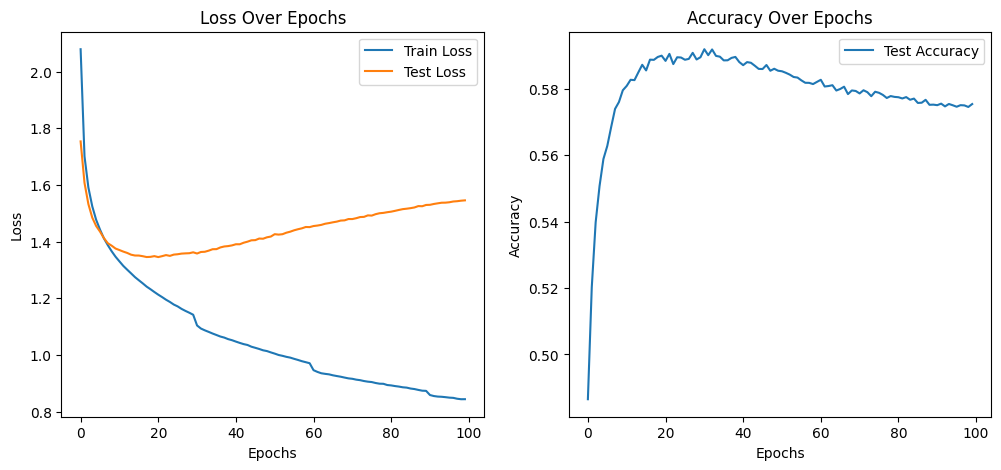

Predicted next character: 'n'


In [2]:
#Problem 2: LSTM Lenght 20
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 20

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized LSTM model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        return output

# Step 6: Hyperparameters
hidden_size = 256
learning_rate = 0.0003
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
          f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=20):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 2: LSTM Length 30
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 30

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized LSTM model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        return output

# Step 6: Hyperparameters
hidden_size = 256
learning_rate = 0.0003
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
          f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=30):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 2: LSTM Length 50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 50

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized LSTM model
class LSTMCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        return output

# Step 6: Hyperparameters
hidden_size = 256
learning_rate = 0.0003
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = LSTMCharModel(len(chars), hidden_size, len(chars), num_layers=2, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
          f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=50):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")


In [ ]:
#Problem 2: GRU Length 20
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 20

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized GRU model
class GRUCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.4):
        super(GRUCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(output_size)  # Batch normalization for stability

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        output = self.batch_norm(output)  # Apply batch normalization
        return output

# Step 6: Hyperparameters
hidden_size = 512  # Increased hidden size for better learning capacity
learning_rate = 0.0005  # Adjusted for GRU optimization
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = GRUCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()  # Start timer for this epoch
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Initialize tqdm progress bar
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        # Update progress bar dynamically
        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()  # Close tqdm bar after epoch completes
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Update final epoch progress bar instead of printing separately
    pbar.write(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
               f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# End measuring total execution time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=20):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

# Step 9: Plot training loss, test loss, and test accuracy

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Problem 2: GRU Length 30
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 30

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized GRU model
class GRUCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.4):
        super(GRUCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(output_size)  # Batch normalization for stability

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        output = self.batch_norm(output)  # Apply batch normalization
        return output

# Step 6: Hyperparameters
hidden_size = 512  # Increased hidden size for better learning capacity
learning_rate = 0.0005  # Adjusted for GRU optimization
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = GRUCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()  # Start timer for this epoch
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Initialize tqdm progress bar
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        # Update progress bar dynamically
        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()  # Close tqdm bar after epoch completes
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Update final epoch progress bar instead of printing separately
    pbar.write(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
               f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# End measuring total execution time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=30):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

# Step 9: Plot training loss, test loss, and test accuracy

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Problem 2: GRU Length 50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for live progress bar

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

# Step 2: Prepare the dataset
sequence_length = 20

# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = np.array([char_to_int[ch] for ch in text], dtype=np.int16)

# Step 3: Dataset class (loads only when needed to reduce memory usage)
class CharDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.encoded_text) - self.sequence_length

    def __getitem__(self, index):
        sequence = self.encoded_text[index:index + self.sequence_length]
        target = self.encoded_text[index + self.sequence_length]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(encoded_text, sequence_length)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2, pin_memory=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Define the optimized GRU model
class GRUCharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.4):
        super(GRUCharModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(output_size)  # Batch normalization for stability

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Take last output for prediction
        output = self.batch_norm(output)  # Apply batch normalization
        return output

# Step 6: Hyperparameters
hidden_size = 512  # Increased hidden size for better learning capacity
learning_rate = 0.0005  # Adjusted for GRU optimization
epochs = 100
clip_norm = 5.0

# Initialize model, loss function, optimizer
model = GRUCharModel(len(chars), hidden_size, len(chars), num_layers=3, dropout=0.4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Start measuring total execution time
total_start_time = time.time()

# Step 7: Training loop with complete epoch summary in tqdm
for epoch in range(epochs):
    epoch_start_time = time.time()  # Start timer for this epoch
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Initialize tqdm progress bar
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch", leave=True)

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        train_accuracy = correct / total

        # Update progress bar dynamically
        pbar.set_postfix(loss=loss.item(), acc=f"{train_accuracy*100:.2f}%")
        pbar.update(1)

    pbar.close()  # Close tqdm bar after epoch completes
    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            test_loss += criterion(output, batch_y).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    test_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Update final epoch progress bar instead of printing separately
    pbar.write(f"Epoch {epoch+1}/{epochs} | Time: {time.time() - epoch_start_time:.2f}s | "
               f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]*100:.2f}%")

# End measuring total execution time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Step 8: Prediction function
def predict_next_char(model, char_to_int, int_to_char, initial_str, max_length=50):
    model.eval()
    with torch.no_grad():
        input_seq = [char_to_int[c] for c in initial_str[-max_length:] if c in char_to_int]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return int_to_char[predicted_index]

# Predict the next character
test_str = "To be or not to be, that is "
predicted_char = predict_next_char(model, char_to_int, int_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

# Step 9: Plot training loss, test loss, and test accuracy

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()
